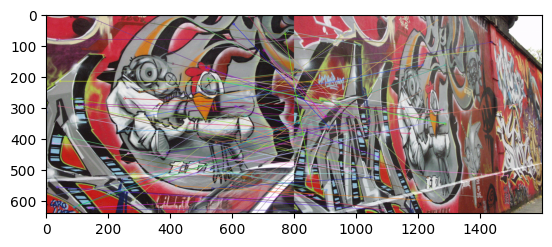

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the images
image1 = cv2.imread('graf/img1.ppm')
image2 = cv2.imread('graf/img5.ppm')

sift = cv2.SIFT_create()  # Initialize the SIFT detector
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)  # Find the keypoints and descriptors for both images
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)
bf = cv2.BFMatcher()  # Create a Brute Force Matcher
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.show()


In [7]:
THRESHOLD = 0.55
NUM_ITERS = 1000

def compute_homography(pairs):  # function to compute homography
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1 / H.item(8)) * H
    return H

def point_distance(pair, H):  # function to compute distance between points in image 1 and image 2
    p1 = np.array([pair[0], pair[1], 1])
    p2 = np.array([pair[2], pair[3], 1])
    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    return np.linalg.norm(np.transpose(p2) - p2_estimate)

def ransac(point_map, threshold=THRESHOLD):  # function to compute RANSAC
    best_inliers = set()
    homography = None
    for i in range(NUM_ITERS):
        pairs = [point_map[i] for i in np.random.choice(len(point_map), 4)]
        H = compute_homography(pairs)
        inliers = {(c[0], c[1], c[2], c[3])
                   for c in point_map if point_distance(c, H) < 500}
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            homography = H
            if len(best_inliers) > (len(point_map) * threshold):
                break
    return homography, best_inliers

def create_point_map(image1, image2):  # function to create point map between image 1 and image 2
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)
    matches = cv2.BFMatcher(cv2.NORM_L2, True).match(descriptors1, descriptors2)
    point_map = np.array([
        [keypoints1[match.queryIdx].pt[0],
         keypoints1[match.queryIdx].pt[1],
         keypoints2[match.trainIdx].pt[0],
         keypoints2[match.trainIdx].pt[1]] for match in matches
    ])
    return point_map

# Compute homography and inliers
point_mapping = create_point_map(image1, image2)
homography_matrix, inliers_set = ransac(point_mapping)

# Extract src_pts and dst_pts from point_mapping
source_points = np.array([[x1, y1] for x1, y1, _, _ in point_mapping], dtype=np.float32)
destination_points = np.array([[x2, y2] for _, _, x2, y2 in point_mapping], dtype=np.float32)

# Ground truth homography
ground_truth_homography, _ = cv2.findHomography(source_points, destination_points, cv2.RANSAC, 5.0)

# Output results
print(f'Homography Matrix:\n{str(homography_matrix)}')
print(f'Number of Inliers: {len(inliers_set)}')
print(f'Ground Truth Homography Matrix:\n{str(ground_truth_homography)}')


Homography Matrix:
[[ 6.78753642e+00  8.92608243e-01 -4.74092591e+02]
 [ 1.48737324e+01 -4.00987254e+00  4.27149464e+02]
 [ 3.75541695e-02 -9.19249893e-03  1.00000000e+00]]
Number of Inliers: 710
Ground Truth Homography Matrix:
[[ 1.95849831e-01 -7.16221966e-01  3.60930522e+02]
 [ 5.47980888e-03 -5.22810660e-01  2.89220315e+02]
 [ 1.32670972e-04 -1.85173421e-03  1.00000000e+00]]


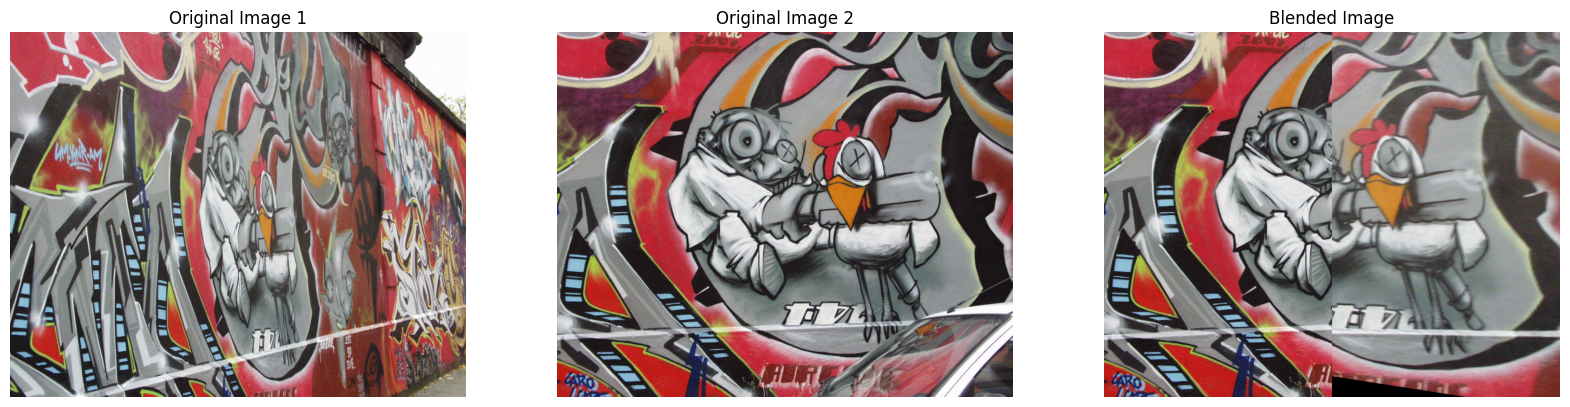

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the two images
image1 = cv2.imread('graf/img5.ppm')
image2 = cv2.imread('graf/img1.ppm')

# Create a copy of the original images for display
image1_display = image1.copy()
image2_display = image2.copy()
points_image1 = []
points_image2 = []

def mouse_click(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(points_image1) < 4:
            points_image1.append((x, y))
            cv2.circle(image1_display, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow('Image 1', image1_display)
        elif len(points_image2) < 4:
            points_image2.append((x, y))
            cv2.circle(image2_display, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow('Image 2', image2_display)

cv2.imshow('Image 1', image1_display)
cv2.setMouseCallback('Image 1', mouse_click)
cv2.imshow('Image 2', image2_display)
cv2.setMouseCallback('Image 2', mouse_click)

# Wait for the user to select points in both images
while True:
    if len(points_image1) == 4 and len(points_image2) == 4:
        break
    cv2.waitKey(1)

cv2.destroyAllWindows()

points_image1 = np.array(points_image1, dtype=np.float32)  # Convert selected points to NumPy arrays
points_image2 = np.array(points_image2, dtype=np.float32)

homography_matrix, _ = cv2.findHomography(points_image1, points_image2, cv2.RANSAC, 5.0)  # Compute the homography matrix using the selected points

height, width = image2.shape[:2]  # Warp image1 to align with image2
aligned_image1 = cv2.warpPerspective(image1, homography_matrix, (width, height))
mask = np.zeros_like(image2, dtype=np.uint8)  # Create a mask to blend the overlapping parts
mask[:, :width // 2] = 255
result = cv2.bitwise_and(image2, mask) + cv2.bitwise_and(aligned_image1, 255 - mask)  # Blend the two images using the mask

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image 1')
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
ax[1].set_title('Original Image 2')
ax[1].axis('off')
ax[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax[2].set_title('Blended Image')
ax[2].axis('off')

plt.show()

